# ROA Estimation for the Time-Reversed Van der Pol Oscillator

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
from pydrake.all import (
    MathematicalProgram,
    RealContinuousLyapunovEquation,
    Solve,
    Variables,
)
from pydrake.examples import VanDerPolOscillator

from underactuated import plot_2d_phase_portrait

# increase default size matplotlib figures
rcParams["figure.figsize"] = (6, 6)

## Problem Description
In this notebook we will study the time-reversed Van der Pol oscillator.
The equations of motion for this system are polynomial, and read as follows:
$$\begin{aligned}\dot x_1 &= - x_2, \\ \dot x_2 &= x_1 + (x_1^2 - 1) x_2.\end{aligned}$$
We compactly represent the latter as $\dot{\mathbf{x}} = f(\mathbf{x})$, with $\mathbf{x} = [x_1, x_2]^T$.

In [2]:
# function that implements the time-reversed Van der Pol dynamics
f = lambda x: [-x[1], x[0] + (x[0] ** 2 - 1) * x[1]]

Here is the phase portrait of the time-reversed Van der Pol oscillator.

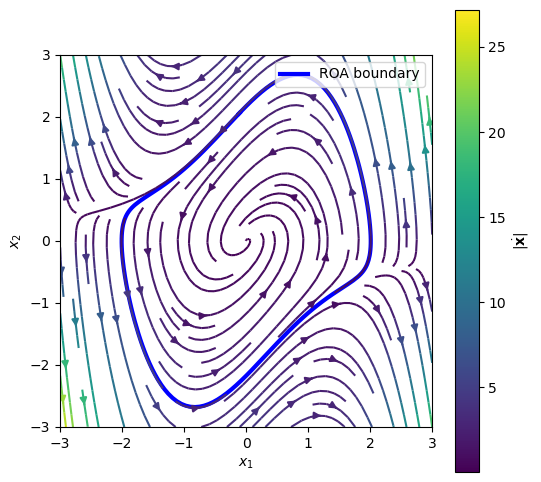

In [3]:
# compute and plot the unstable periodic orbit
limit_cycle = VanDerPolOscillator.CalcLimitCycle()
plt.plot(
    limit_cycle[0],
    limit_cycle[1],
    color="b",
    linewidth=3,
    label="ROA boundary",
)
plt.legend(loc=1)

# plot the phase portrait
xlim = (-3, 3)
plot_2d_phase_portrait(f, x1lim=xlim, x2lim=xlim)


As you can see, the origin of this system is locally asymptotically stable whereas, outside the Region Of Attraction (ROA) of the origin, the trajectories escape to infinity. The boundary of the ROA is an *unstable periodic orbit*: if the system state at time $t=0$ is exactly on this curve, the oscillator will orbit around the origin forever. However, any disturbance will make the system either converge to the origin or escape to infinity. Notice that the shape of this ROA is nontrivial (it is not even a convex set) and no analytic description of it is available.

**Note:** Reversing the sign of $f$, we obtain the [classical Van der Pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator); for which the above periodic orbit is a (globally) asymptotically stable [limit cycle](https://underactuated.csail.mit.edu/simple_legs.html#limit_cycle) and the origin is an unstable equilibrium. Here we reverse time (i.e. change the sign of $f$) to make the origin a stable equilibrium.

**In this notebook we will use Sums-Of-Squares (SOS) optimization to find an inner approximation of the ROA of the equilibrium point in the origin. We will write three different SOS optimizations, and analyze their pros and cons.**

## Lyapunov Function via Linearization
The approach we will follow to estimate the ROA of the oscillator is the following:

- We linearize the dynamics $\dot{\mathbf{x}} = f(\mathbf{x})$ around the origin, to get $\dot{\mathbf{x}} = A \mathbf{x}$.

- We solve the Lyapunov equation $$A^T P + P A = - Q$$ to get the positive definite matrix $P$, and the Lyapunov function $V(\mathbf{x}) = \mathbf{x}^T P \mathbf{x}$ for the linearized system. **Note**: A standard choice for $Q$ is an identity matrix.

- Lyapunov theory tells us that if $A$ is strictly stable (all its eigenvalues have strictly negative real part) then the origin is a locally asymptotically stable equilibrium point for the nonlinear system $\dot{\mathbf{x}} = f(\mathbf{x})$.
Moreover, a conservative approximation of the ROA can be obtained using the Lyapunov function $V(\mathbf{x})$ derived in the linear analysis.

- We consider the level sets $$L(\rho) = \{ \mathbf{x} : V(\mathbf{x}) \leq \rho \},$$ and we look for the maximum value of $\rho$ such that $$\dot{V}(\mathbf{x}) = \frac{\partial V}{\partial \mathbf{x}} f(\mathbf{x}) = 2 \mathbf{x}^T P f(\mathbf{x}) < 0, \quad \forall \mathbf{x} \in L(\rho)\backslash \{0\}.$$
In words, we try to find the largest level set $L(\rho)$ entirely contained the region of space where $\dot{V}(\mathbf{x})$ is negative.
Lyapunov theory tells us that any trajectory that starts inside such a set will eventually converge to the origin.

We start by deriving $V(\mathbf{x})$. In the next cell, write down the matrix $A$ (obtained by linearizing $f(x)$ near the origin), the positive definite matrix $Q$, and compute $P$ using the drake function `RealContinuousLyapunovEquation`

In [4]:
A = np.array([[0, -1], [1, -1]])  # MODIFY HERE
Q = np.eye(2)
P = RealContinuousLyapunovEquation(A, Q)  # MODIFY HERE

### Manual Check
The advantage of working in 2D is that we can plot things!
Before starting with complicated optimizations, let us plot $V(\mathbf{x})$ and $\dot{V}(\mathbf{x})$ to get a sense of what we are actually looking for in this analysis.

In [5]:
# function that given rho plots the boundary
# of the the set L(rho) defined above


def plot_V(rho):
    # grid of the state space
    x1 = np.linspace(*xlim)
    x2 = np.linspace(*xlim)
    X1, X2 = np.meshgrid(x1, x2)

    # function that evaluates V(x) at a given x
    # (looks bad, but it must accept meshgrids)
    eval_V = lambda x: sum(
        sum(x[i] * x[j] * Pij for j, Pij in enumerate(Pi)) for i, Pi in enumerate(P)
    )

    # contour plot with only the rho level set
    cs = plt.contour(
        X1,
        X2,
        eval_V([X1, X2]),
        levels=[rho],
        colors="r",
        linewidths=3,
        zorder=3,
    )

    # misc plot settings
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.gca().set_aspect("equal")

    # fake plot for legend
    plt.plot(
        0,
        0,
        color="r",
        linewidth=3,
        label=r"$\{ \mathbf{x} : V(\mathbf{x}) = \rho \}$",
    )
    plt.legend()

    return cs


# function that plots the levels sets of Vdot(x)
def plot_Vdot():
    # grid of the state space
    x1 = np.linspace(*xlim)
    x2 = np.linspace(*xlim)
    X1, X2 = np.meshgrid(x1, x2)

    # function that evaluates Vdot(x) at a given x
    eval_Vdot = lambda x: 2 * sum(
        sum(x[i] * f(x)[j] * Pij for j, Pij in enumerate(Pi)) for i, Pi in enumerate(P)
    )

    # contour plot with only the rho level set
    cs = plt.contour(
        X1,
        X2,
        eval_Vdot([X1, X2]),
        colors="b",
        levels=np.linspace(-10, 40, 11),
    )
    plt.gca().clabel(cs, inline=1, fontsize=10)

    # misc plot settings
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.gca().set_aspect("equal")

    # fake plot for legend
    plt.plot(0, 0, color="b", label=r"$\dot{V}(\mathbf{x})$")
    plt.legend()

    return cs

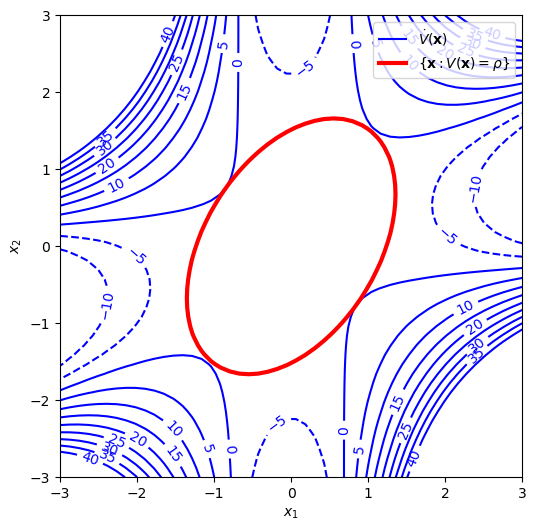

In [6]:
# tune rho by hand to make it as big as possible
# while staying in the region where Vdot(x) is negative
rho_max = 2.3

# plot Vdot(x) and V(x) = rho
Vdot_cs = plot_Vdot()
V_cs = plot_V(rho_max)

With correct values of $A$ and $P$, you will see that the largest $\rho$ for which $\dot{V}(\mathbf{x}) < 0$ is $\approx 2.3$. The red elliptical curve (that represents the 2.3 level set for $V(\mathbf{x})$) touches the zero-valued contours for $\dot{V}(\mathbf{x})$. 
Superimposing the level set to the phase portrait, we see that this is a pretty good approximation of the ROA. 

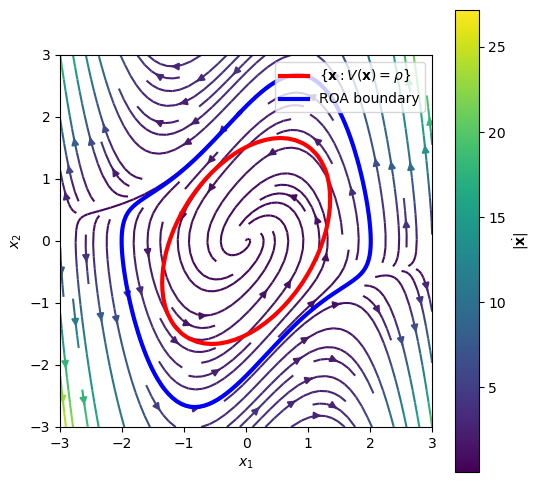

In [7]:
plot_2d_phase_portrait(f, x1lim=xlim, x2lim=xlim)
plot_V(rho_max)
plt.plot(
    limit_cycle[0],
    limit_cycle[1],
    color="b",
    linewidth=3,
    label="ROA boundary",
)
plt.legend(loc=1)

Of course, when $\text{dim}(\mathbf{x}) > 2$, a "manual" maximization of $\rho$ has no hope to work.
That's where SOS programming really makes the difference!
The goal of this notebook is to experiment these tools on a case where things can actually be visualized, so that we get a better sense of the power of this technique.

## Method 1: Line-Search on $\rho$
The first method we use to estimate the ROA is the one from the textbook example "[Region of attraction for the one-dimensional cubic system](https://underactuated.csail.mit.edu/lyapunov.html#roa_cubic_system)".

We look for the largest $\rho$ for which there exists a SOS polynomial $\lambda(\mathbf{x})$ such that $$- \dot{V}(\mathbf{x}) - \lambda(\mathbf{x}) (\rho - V(\mathbf{x})) - \epsilon \mathbf{x}^T \mathbf{x} \ \text{is SOS},$$
with $\epsilon$ very small.
This problem cannot be written as a single SOS program, since both the polynomial $\lambda$ and scalar $\rho$ are decision variables, which are here multiplied together. Hence we naively solve a sequence of SOS programs with increasing value of $\rho$.

The intuition behind this formulation is the following.
Think of the condition "is SOS" as "$\geq 0$" (actually, the first is sufficient for the second).
Then what we are asking is $- \dot{V}(\mathbf{x}) \geq \lambda(\mathbf{x}) (\rho - V(\mathbf{x})) + \epsilon \mathbf{x}^T \mathbf{x}$. 
Inside the level set $L(\rho)$, we have $\rho - V(\mathbf{x}) \geq 0$ and, since $\lambda(\mathbf{x})$ is SOS, $\lambda(\mathbf{x}) (\rho - V(\mathbf{x})) \geq 0$.
Thus the condition above is just sayng that, for all $\mathbf{x}$ in $L(\rho)$, we must have $- \dot{V}(\mathbf{x})\geq \epsilon \mathbf{x}^T \mathbf{x}$, i.e., $\dot{V}(\mathbf{x})$ negative definite.

Carefully read the following code, as later you will be asked to write similar mathmatical programs. The following drake [tutorial on SOS](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/sum_of_squares_optimization-4137868b87ee423dbc50d0076f72bbb9) can be helpful.

In [8]:
# function that verifies the condition described above
# for the level set L(rho) for a given rho


def is_verified(rho):
    # initialize optimization problem
    # (with Drake there is no need to specify that
    # this is going to be a SOS program!)
    prog = MathematicalProgram()

    # SOS indeterminates
    x = prog.NewIndeterminates(2, "x")

    # Lyapunov function
    V = x.dot(P).dot(x)
    V_dot = 2 * x.dot(P).dot(f(x))

    # degree of the polynomial lambda(x)
    # no need to change it, but if you really want to,
    # keep l_deg even (why?) and do not set l_deg greater than 10
    # (otherwise optimizations will take forever)
    l_deg = 4
    assert l_deg % 2 == 0

    # SOS Lagrange multipliers
    l = prog.NewSosPolynomial(Variables(x), l_deg)[0].ToExpression()

    # main condition above
    eps = 1e-3  # do not change
    prog.AddSosConstraint(-V_dot - l * (rho - V) - eps * x.dot(x))

    # solve SOS program
    # no objective function in this formulation
    result = Solve(prog)

    # return True if feasible, False if infeasible
    return result.is_success()

Now that we have the building block of our algorithm, it's your time to write the line search to find the maximum $\rho$ for which the condition described above holds.

Implement the line search in next cell.
Start with `rho = 0`, check if the level set $L(\rho)$ is verified (i.e. the function `is_verified(rho)` returns `True`); if yes, increase `rho` by `rho_step = .01`, if no, assign to the variable `rho_method_1` the maximum verified `rho` you've found with this procedure.

In [9]:
# implement your line-search here

rho = 0
rho_verified = rho
rho_step = .01
while is_verified(rho):
    rho_verified = rho
    rho += rho_step

# set the maximum value of rho you've found with line search
rho_method_1 = rho_verified  # MODIFY HERE

print(f"Method 1 verified rho = {rho_method_1}.")

Method 1 verified rho = 2.299999999999995.


Did this method do a good job in approximating (from below) the maximum $\rho$ we have found by hand?

## Method 2: Single-Shot SOS Program
With the previous formulation we had to solve a sequence of SOS programs, now we consider an equivalent formulation of the SOS problem in which we can directly maximize $\rho$.
In the previous case we wrote a SOS program to check the implication
$$\mathbf{x} \in L(\rho) \Rightarrow \dot{V}(\mathbf{x}) < 0.$$
This, however, can be equivalently stated as
$$\dot{V}(\mathbf{x}) \geq 0 \Rightarrow \mathbf{x} \not\in L(\rho).$$
Expressing $\mathbf{x} \not\in L(\rho)$ as $V(\mathbf{x}) - \rho \geq 0$, it turns out that the latter condition can be verified with a single SOS program.
(Actually, we should say $V(\mathbf{x}) - \rho > 0$, but working with a computer there is no difference.)

The new problem reads as follows.
Find an SOS polynomial $\lambda(\mathbf{x})$ such that
$$V(\mathbf{x}) - \rho - \lambda(\mathbf{x}) \dot{V}(\mathbf{x}) \ \text{is SOS}.$$
In fact, this implies $V(\mathbf{x}) - \rho \geq \lambda(\mathbf{x}) \dot{V}(\mathbf{x})$ and, for all $\mathbf{x}$ where $\dot{V}(\mathbf{x}) \geq 0$, we get $V(\mathbf{x}) - \rho \geq 0$.

Notice that now $\lambda$ does not multiply $\rho$, and we can search over both of them at the same time.
Hence we can ask the optimizer to maximize $\rho$.
There is however an issue with the current problem formulation...

### Not quite there yet...

Do you see anything wrong with the problem formulation we put together so far? What do you think the maximum $\rho$ will be?

As stated so far, the problem will always return $\rho = 0$!
To see why, first notice that for $\rho = \lambda = 0$ the SOS condition above would become $V(\mathbf{x})$ is SOS, which holds since $V(\mathbf{x}) = \mathbf{x}^T P \mathbf{x}$.
Now consider a positive $\rho$.
Since $V(0) = \dot{V} (0) = 0$, evaluating the SOS condition in the origin, we would get $-\rho \geq 0$ which can never hold!

Not everything is lost, we have a neat fix for you.
Certainly, if $V(\mathbf{x}) - \rho$ is nonnegative, so is $\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho)$.
Hence we consider the SOS condition
$$\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho) - \lambda(\mathbf{x}) \dot{V}(\mathbf{x}) \ \text{is SOS},$$
with $\lambda(\mathbf{x})$ SOS.
Now the issue in the origin is fixed, since for $\mathbf{x} = 0$, we get "$0$ is SOS", which is always true.
Moreover, where $\mathbf{x}$ is such that $\dot{V}(\mathbf{x}) \geq 0$, the new SOS condition requires $\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho) \geq 0$ and hence $V(\mathbf{x}) - \rho \geq 0$ as desired.

Now we are good to go!

In the next cell you need to code the SOS program we just described. Refer to the previous code block and the [drake tutorial](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/sum_of_squares_optimization-4137868b87ee423dbc50d0076f72bbb9) for hint on writing SOS programs. 

In [10]:
# initialize optimization problem
prog2 = MathematicalProgram()  # Do not modify

# 1. define SOS indeterminates
x = prog2.NewIndeterminates(2, "x")

# 2. define Lyapunov function and its derivative
V = x.dot(P).dot(x)
V_dot = 2 * x.dot(P).dot(f(x))

# 3. define SOS Lagrange multipliers, with any even degree between 4 and 10
l_deg = 4
assert l_deg % 2 == 0
l = prog2.NewSosPolynomial(Variables(x), l_deg)[0].ToExpression()

# 4. define 'rho' (level set) as optimization variable
rho = prog2.NewContinuousVariables(1, "rho")[0]

# 5. write the SOS constraints as discussed above
prog2.AddSosConstraint(x.dot(x) * (V - rho) - l * V_dot)

# 6. write the objective function (use AddLinearCost)
prog2.AddLinearCost(-rho)

# 7. call the solver on the mathematical program, and set the value of rho_method_2 below.
result = Solve(prog2)

rho_method_2 = result.GetSolution(rho)

print(f"Method 2 verified rho = {rho_method_2}.")

Method 2 verified rho = 2.3044775752953925.


## Method 3: Smarter Single-Shot SOS Program
The SOS program we just wrote was already a satisfying solution, but it turns out we can do even better!
From the textbook chapter "[Lyapunov analysis with convex optimization](https://underactuated.csail.mit.edu/lyapunov.html#optimization)", you know that every SOS constraint brings with it a lot of optimization variables and an SDP constraint.
So, whenever we can, removing redundant SOS requirements is always a good thing to do.

We claim that in the previous formulation we don't need $\lambda(\mathbf{x})$ to be SOS. How is this possible?

We start by noticing that, in a neighborhood of the origin, excluded the origin itself, $\dot{V}(\mathbf{x})$ is strictly negative.
(This because $V(\mathbf{x})$ is a Lyapunov function for the linearized system hence, locally, it works also for the nonlinear system.)

In light of the latter observation, instead of asking that $\dot{V}(\mathbf{x})$ is negative for all $\mathbf{x} \neq 0$ in $L(\rho)$, we can equivalently ask that all the points $\mathbf{x} \neq 0$ where $\dot{V}(\mathbf{x}) = 0$ must be outside the level set $L(\rho)$.
This might take a second to parse!

The latter condition can be enforced exactly as the one above:
$$\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho) - \lambda(\mathbf{x}) \dot{V}(\mathbf{x}) \ \text{is SOS},$$
but this time we do not require $\lambda(\mathbf{x})$ to be SOS.

Here is the reasoning.
First, notice that this condition implies $\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho) \geq \lambda(\mathbf{x}) \dot{V}(\mathbf{x})$.
Then, observe that for all $\mathbf{x}$ such that $\dot{V}(\mathbf{x}) = 0$, we get $\mathbf{x}^T\mathbf{x}(V(\mathbf{x}) - \rho) \geq 0$.
This implies $V(\mathbf{x}) - \rho \geq 0$, i.e., $\mathbf{x} \not\in L(\rho)$ as desired.
(As before, no need to care about what happens at the boundary of the level set.)

This trick can make a huge difference when you need to verify high-dimensional systems!

To try this new idea, in the next cell define the third mathematical program that has only one SOS constraint. **Note:** Do not use `NewSosPolynomial` for defining $\lambda(x)$, instead use `NewFreePolynomial`. If you have done thing correctly, `rho_method_3` should "closely match" `rho_method_2`!

In [11]:
# initialize optimization problem
prog3 = MathematicalProgram()  # Do not modify

# Write the modified Single-Shot SOS program here. Make sure there is only one SOS constraint.
x = prog3.NewIndeterminates(2, "x")
V = x.dot(P).dot(x)
V_dot = 2 * x.dot(P).dot(f(x))
l_deg = 4
l = prog3.NewFreePolynomial(Variables(x), l_deg).ToExpression()
rho = prog3.NewContinuousVariables(1, "rho")[0]
prog3.AddSosConstraint(x.dot(x) * (V - rho) - l * V_dot)
prog3.AddLinearCost(-rho)
result = Solve(prog3)
rho_method_3 = result.GetSolution(rho)  # MODIFY HERE

print(f"Method 3 verified rho = {rho_method_3}.")

Method 3 verified rho = 2.3044775712602963.


## Final Note
More advanced techniques to approximate ROAs are available.
Generally they require some sort of alternation between optimizing over the multiplier $\lambda$ (as we did here) and modifying the shape of the Lyapunov function $V(\mathbf{x})$, e.g., by considering higher-order polynomials (here we stuck to the quadratic one coming from
linear analysis).
The level set $\rho$ is generally kept fixed (e.g. equal to unity) since, when reshaping the Lyapunov function, the optimizer is allowed to scale the range of this function arbitrarily.

Here is an image of SOS in its full glory approximating the ROA of the Van der Pol oscillator.
Impressive, isn't it?!

![figure](https://raw.githubusercontent.com/RussTedrake/underactuated/master/book/figures/exercises/van_der_pol_roa.png)
(Courtesy of Shen Shen.)

## Autograding
You can check your work by running the following cell:

In [12]:
from underactuated.exercises.grader import Grader
from underactuated.exercises.lyapunov.test_van_der_pol import TestVanDerPol

Grader.grade_output([TestVanDerPol], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 15/15.

Score for Test linearization matrix A is 1/1.

Score for Test lyapunov matrices is 1/1.

Score for Test level set for Method 1 is 3/3.

Score for Test level set for Method 2 is 5/5.

Score for Test level set for Method 3 is 5/5.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=13df87c4-ef0f-41cd-8921-0f3bf79667b0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>